#  This is a simple machine learning example

First, we need to load the required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Cambria"
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

Next, we need to load our data!

In [2]:
df=pd.read_csv('C:\\Users\\kelvi\\Desktop\\HMT_-_2011_Air_Data.csv') 
# dataset found here: https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/245855/HMT_-_2011_Air_Data.csv
# and has been adjusted slightly before loading

Let's have a quick look at this dataset

In [3]:
types = df.dtypes
print(types)

Agency                  object
Paid_fare              float64
Trip type               object
Routing_type            object
Ticket class            object
Departure Date          object
Origin                  object
Destination             object
Destination Country     object
Carrier                 object
dtype: object


And are there any null values?

In [4]:
#get summary
df.info()
# no null values which is good!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Agency               671 non-null    object 
 1   Paid_fare            671 non-null    float64
 2   Trip type            671 non-null    object 
 3   Routing_type         671 non-null    object 
 4   Ticket class         671 non-null    object 
 5   Departure Date       671 non-null    object 
 6   Origin               671 non-null    object 
 7   Destination          671 non-null    object 
 8   Destination Country  671 non-null    object 
 9   Carrier              671 non-null    object 
dtypes: float64(1), object(9)
memory usage: 52.5+ KB


Given that our dataset has quite a lot of text values, we'll remove some of these and simplify others to make it "nicer" for our machine learning model to make use of.

In [5]:
# first, we will remove any negative values for "Paid fare" since this is what we want to try and predict
# then we will change the column data type from float to int
df = df[df['Paid_fare']>=0]
df['Paid_fare'] = df['Paid_fare'].astype(int)

# next we'll make sure departure date is a date
# convert the date to datetime date values
df['Departure Date'] = pd.to_datetime(df['Departure Date'],format="%d/%m/%Y").dt.date

# and we will remove the unnecessary "Agency" column
# we can drop some unnecessary columns
df = df.drop(columns=['Agency'])

#  Data modification

For this next part - we'll focus on removing any instances in our dataset that only have a singular occurrence - this is for columns like the Carrier, Origin and/or Destination. We'll make some grouped datasets and rejoin these to the main dataset, and also use a custom function to achieve these aims.

In [6]:
# first, we'll take a look at the Carrier column
# let's see how frequently the carriers occur
df_carrier = df.groupby(['Carrier'])['Paid_fare'].count().reset_index()
df_carrier = df_carrier.sort_values(['Paid_fare'],ascending=False)
df_carrier['Pct'] = round((df_carrier['Paid_fare']/sum(df_carrier['Paid_fare']))*100,1)
df_carrier.rename(columns={'Paid_fare':'Count'},inplace=True)
df_carrier.head()

,Carrier,Count,Pct
13,BRITISH AIRWAYS,296,45.7
12,BMI,69,10.7
28,FLYBE BRITISH EUROPEAN,31,4.8
5,AIR FRANCE,29,4.5
38,LUXAIR,27,4.2


Now we can join this back to the main df and remove any instances occurring only once

In [7]:
# we also need to remove any instances of carrier with only 1 entry
df = pd.merge(df,df_carrier,how="left",on=['Carrier'])
df = df[df['Count']>1]

We can now do the same thing for Origin and Destination

In [8]:
# group-by
df_ori = df.groupby(['Origin'])['Paid_fare'].count().reset_index()
df_ori.rename(columns={'Paid_fare':'Count_ori'},inplace=True)

df_des = df.groupby(['Destination'])['Paid_fare'].count().reset_index()
df_des.rename(columns={'Paid_fare':'Count_des'},inplace=True)

# re-join to df
df=pd.merge(df,df_ori,how="left",on=['Origin'])
df=pd.merge(df,df_des,how="left",on=['Destination'])

# filter
df=df[df['Count_ori']>1]
df=df[df['Count_des']>1]

Next we will make a custom function for the routing type, apply it and use it to filter the data

In [9]:
def trip_type(value):
    if value['Routing_type']=='ONE-WAY':
        return 0
    elif value['Routing_type']=='ROUND TRIP':
        return 1
    else:
        return 2

df['Trip typer'] = df.apply(trip_type,axis=1)

df = df[df['Trip typer']!=2]

# Get data ready for machine learning
Here we can get out data ready - by removing any extra columns and specifying our training dataset.
Since we want to try and predict the Price paid - we'll remove this from our train dataset.

In [10]:
# drop extra columns
df = df.drop(columns=['Count','Pct','Count_ori','Count_des','Trip typer'])

# make training dataset
df_train = df.drop(columns=['Paid_fare'])

# Create a data pipeline classification
Let's create a data pipeline base, to use for our training and testing datasets 

In [11]:
num_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

cat_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent",fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown='ignore')),
    ])

Here we will define our X and y variables for the machine learning datasets, as well as the sample size

In [12]:
y = df['Paid_fare']

X = df_train

sample = 0.3 #size of test dataset

#default train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=sample,random_state=42,shuffle=True)

And we will define how the pipeline should work on the data. Note this is chosen to be after defining the train and test datasets (it can also be before - but in this case it is chosen to be after).

In [13]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, numeric_features),
        ("cat", cat_pipeline, categorical_features),
    ])

# Machine Learning modelling¶
Now that we've defined how our data and pipeline should be used, we can start the machine learning process. We'll focus on two model types - Logistic Regression and Random Forest Regressor

In [14]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

# use the data Pipeline
model_lr = Pipeline(steps=[('preprocessor',preprocess_pipeline),('model',log_reg)])

# fit the model on the training dataset
model_lr.fit(X_train,y_train)

# test the model on the training dataset
model_train_lr = model_lr.predict(X_train)

# test the model on the testing dataset
model_test_lr = model_lr.predict(X_test)

Get the model cross val score

In [15]:
lr = cross_val_score(model_lr, X_train, y_train,cv=3)
lr.mean()

0.28953381241938453

A score ~ 30% - not very good. Let's visualise the train and test data to see how (badly) the model did.

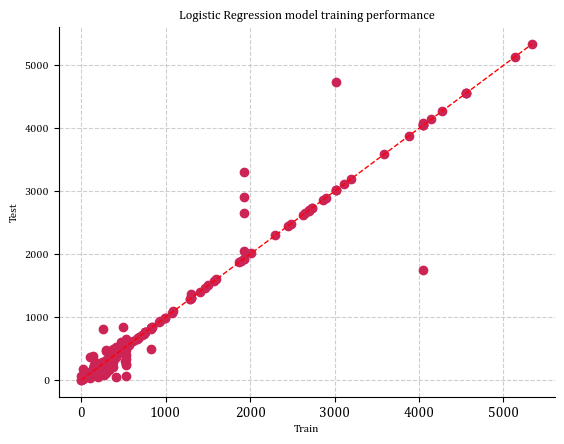

In [16]:
fig, ax = plt.subplots()

ax.scatter(model_train_lr, y_train, color='#CD2456')
max_val = max([model_train_lr.max(), y_train.max()])
ax.plot([0,max_val], [0,max_val],color='red',lw=1,ls='--')

# Customise some display properties for line graph
ax.set_ylabel('Test',size=8)
ax.set_xlabel('Train',size=8)
ax.set_title('Logistic Regression model training performance',size=9)
ax.set_axisbelow(True)
ax.grid(linestyle='--',color='#CECECE')
ax.tick_params(axis='y',labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

There are a few instances that differ markedly from the actual training dataset, although on the whole model predictions seem reasonable close to the actual training values. The red dashed line is where the test (actual) values meet the train (prediction) values. Where most prediction values are exactly equal to the actual values, this is known as "overfitting" and means that the model is highly specialised to the training data - any new or different values than what has been seen in the training data will mean significantly reduced model performance.

Let's also look at the performance to the test dataset below - and illustrate the above point.

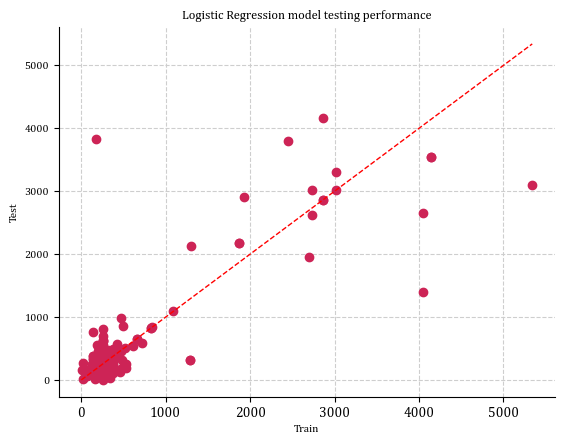

In [17]:
fig, ax = plt.subplots()

ax.scatter(model_test_lr, y_test, color='#CD2456')
max_val = max([model_test_lr.max(), y_test.max()])
ax.plot([0,max_val], [0,max_val],color='red',lw=1,ls='--')

# Customise some display properties for line graph
ax.set_ylabel('Test',size=8)
ax.set_xlabel('Train',size=8)
ax.set_title('Logistic Regression model testing performance',size=9)
ax.set_axisbelow(True)
ax.grid(linestyle='--',color='#CECECE')
ax.tick_params(axis='y',labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

For the test data, it's clear the model performed significantly worse when compared to its performance on the train data. Only a few values are on the dashed line, and many more are positioned away it.

Below, we'll repeat the above but this time for a Random Forest Regressor model.

N.B Regressor models are useful for numerical values as outputs whereas Classifier models are useful for classification (text) values as outputs.

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=150)

# use the data Pipeline
model_rfr = Pipeline(steps=[('preprocessor',preprocess_pipeline),('model',rfr)])

# fit the model on the training dataset
model_rfr.fit(X_train,y_train)

# test the model on the training dataset
model_train_rfr = model_rfr.predict(X_train)

# test the model on the testing dataset
model_test_rfr = model_rfr.predict(X_test)

Again, let's get the model cross val score

In [19]:
rfr_score = cross_val_score(model_rfr, X_train, y_train,cv=3)
rfr_score.mean()

0.8561259109878003

This performs significantly better than our Logistic Regression model... we will visualise the train and test performance again

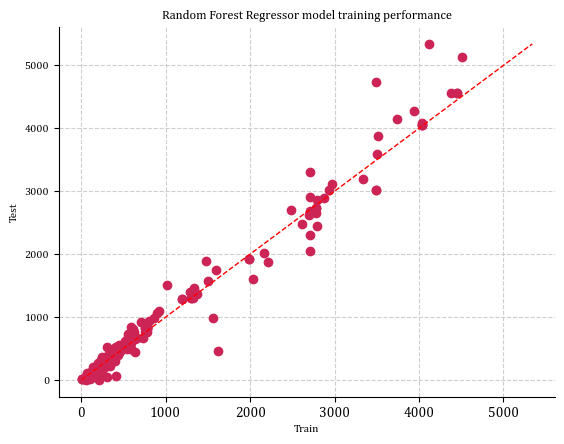

In [20]:
fig, ax = plt.subplots()

ax.scatter(model_train_rfr, y_train, color='#CD2456')
max_val = max([model_train_rfr.max(), y_train.max()])
ax.plot([0,max_val], [0,max_val],color='red',lw=1,ls='--')

# Customise some display properties for line graph
ax.set_ylabel('Test',size=8)
ax.set_xlabel('Train',size=8)
ax.set_title('Random Forest Regressor model training performance',size=9)
ax.set_axisbelow(True)
ax.grid(linestyle='--',color='#CECECE')
ax.tick_params(axis='y',labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

This performs better than our Logistic Regression example did on the train data.
How did it perform on the test data?

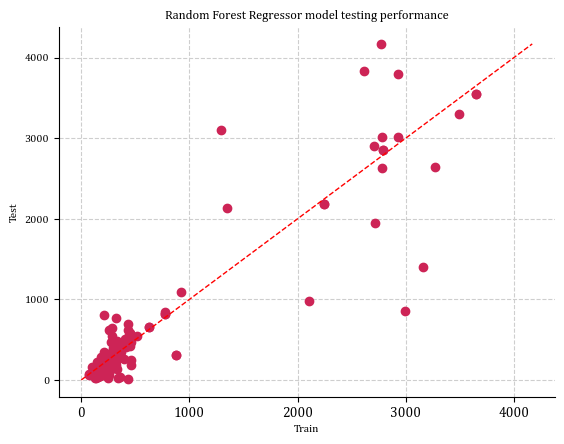

In [21]:
fig, ax = plt.subplots()

ax.scatter(model_test_rfr, y_test, color='#CD2456')
max_val = max([model_test_rfr.max(), y_test.max()])
ax.plot([0,max_val], [0,max_val],color='red',lw=1,ls='--')

# Customise some display properties for line graph
ax.set_ylabel('Test',size=8)
ax.set_xlabel('Train',size=8)
ax.set_title('Random Forest Regressor model testing performance',size=9)
ax.set_axisbelow(True)
ax.grid(linestyle='--',color='#CECECE')
ax.tick_params(axis='y',labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

This is generally better than the Logistic Regression example, as even where predictions differ from the actual (test) values - they do not diverge as far away from the red dashed line.

In either case, a model score of ~ 30% does not give confidence to the predictions being made however what can be seen from the graphs is that the model(s) have learned to predict certain cases well (just not every case).

Therefore in order to increase model accuracy, we will either need to use a more condensed dataset which contains e.g. at-least 10 instances of every occurrence (rather than allowing for 2 as at present), or try to generalise more to allow for easier insight/predictions as to how outcomes (price) are generated.

Finally, we can compare the 3 cross-validation attempts as a visual graph:

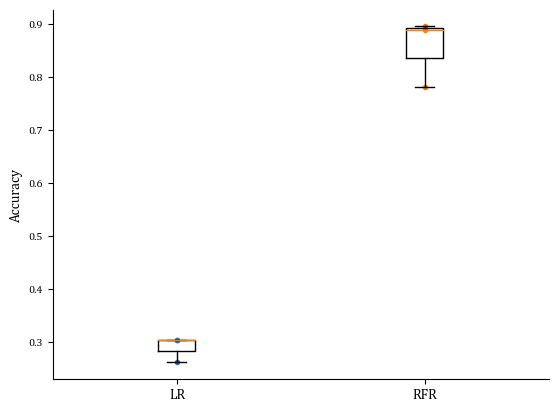

In [22]:
fig, ax = plt.subplots()
#plt.figure(figsize=(8, 4))
ax.plot([1]*3, lr, ".")
ax.plot([2]*3, rfr_score, ".")
ax.boxplot([lr, rfr_score], labels=("LR", "RFR"))
ax.set_ylabel("Accuracy")
ax.set_axisbelow(True)
ax.tick_params(axis='y',labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

From the above, we can see that the RFR model would be the best at generalising (and hence out of the 2 models it would be the best to use). All 3 of it's model runs outperform the LR model in this case.

As a last action, let's look at the mean error of the predictions between the models.

In [23]:
lr_mae = -cross_val_score(model_lr, X_train, y_train, scoring="neg_root_mean_squared_error",cv=3)
lr_mae.mean()

443.8021159357838

In [24]:
rfr_mae = -cross_val_score(model_rfr, X_train, y_train, scoring="neg_root_mean_squared_error",cv=3)
rfr_mae.mean()

349.84261577140757

Hence we can see the average error in the training dataset predictions were +/- 443 for the LR model and +/- 349 for the RFR model. This serves to reinforce our thinking above that the RFR model is the better model to use.

# How can model performance be (slightly) improved? - Hyperparameter adjustments!
Below we can try and adjust some of the RFR hyperparameters to see if we can get any better performance.

In [25]:
# get the pipeline
pipe = Pipeline(steps=[('preprocessor',preprocess_pipeline),('model',rfr)])

# get param grid options
# get a list of what we can alter in the param grid
print(pipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__cat_encoder', 'preprocessor

In [26]:
 # we'll try a selection of parameters to adjust
grid_param = {
    #'model__criterion': [1,10],
    'model__max_depth': [250,500],
    'model__max_features': [50,100],
    'model__max_leaf_nodes': [250,300],
    #'model__max_samples',
    'model__min_samples_leaf': [1,2],
    'model__n_jobs': [-1],
    'model__n_estimators': [950,1000]
    }

# below we'll try a combination of the above over 5 different attempts
from sklearn.model_selection import GridSearchCV
gridSearchProcessor = GridSearchCV(estimator=pipe,
                                   param_grid=grid_param,
                                   cv=5) # 5 different cross-validation attempts

gridSearchProcessor.fit(X_train,y_train)

best_model_type = gridSearchProcessor.best_params_

best_model_score = gridSearchProcessor.best_score_

best_model = gridSearchProcessor.best_estimator_

print(best_model_score)

0.8607776735635573


This performs (slightly) better than the non-hyperparameter customised version. Success!

# Feature importance
We can get a list of (categorical) feature importance to the model below

In [27]:
feature_importance = best_model['model'].feature_importances_
feature_importance.round(2)

feature_importance = sorted(zip(feature_importance,
           preprocess_pipeline.transformers_[1][1]\
              .named_steps['cat_encoder'].get_feature_names(categorical_features)),
           reverse=True) # categorical or numeric selection
    
feature_importance = feature_importance[:20] # first 20 features
feature_importance

[(0.24231378643480891, 'Trip type_Intercontinental'),
 (0.19772881603376796, 'Ticket class_Business Class'),
 (0.14309335877416565, 'Ticket class_Economy'),
 (0.059481429144852944, 'Destination Country_UNITED STATES'),
 (0.0432499270730567, 'Destination_WASHINGTON'),
 (0.02528761393365405, 'Trip type_Continental'),
 (0.023207709026550935, 'Origin_SHANGHAI'),
 (0.014581754441762062, 'Trip type_Domestic'),
 (0.01180493841737753, 'Departure Date_2011-09-22'),
 (0.010922840593896949, 'Carrier_CATHAY PACIFIC AIRWAYS'),
 (0.010673386044273717, 'Destination_BEIJING'),
 (0.010600469993038174, 'Ticket class_Premium Economy'),
 (0.010563266280530021, 'Carrier_VIRGIN ATLANTIC'),
 (0.01032635180302127, 'Destination Country_UNITED KINGDOM'),
 (0.008724549489216242, 'Destination Country_CHINA'),
 (0.008488685063611874, 'Destination_BUENOS AIRES'),
 (0.008121596464950922, 'Departure Date_2011-05-16'),
 (0.00775854987057912, 'Carrier_BRITISH AIRWAYS'),
 (0.007697489545563675, 'Destination Country_ARGE